In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
train_data = train_data.head(5000)
train_data = train_data.drop(['Listed On','Last Sold On','Elementary School','Middle School','High School'],axis=1)
test_data = test_data.drop(['Listed On','Last Sold On','Elementary School','Middle School','High School'],axis=1)

cuda


In [3]:
all_features = pd.concat((train_data.iloc[:, 5:], test_data.iloc[:, 4:])) #按行追加


In [4]:
all_features.head()

,Year built,Heating,Cooling,Parking,Lot,Bedrooms,Bathrooms,Full bathrooms,Total interior livable area,Total spaces,...,Appliances included,Laundry features,Parking features,Tax assessed value,Annual tax amount,Listed Price,Last Sold Price,City,Zip,State
0,1969.0,"Heating - 2+ Zones, Central Forced Air - Gas","Multi-Zone, Central AC, Whole House / Attic Fan","Garage, Garage - Attached, Covered",1.0,"Ground Floor Bedroom, Master Bedroom on Ground...",0.0,NaN,1.0,0.0,...,"Dishwasher, Dryer, Garbage disposal, Microwave...","Washer / Dryer, Inside, In Utility Room","Garage, Garage - Attached, Covered",886486.0,12580.0,4198000.0,NaN,Los Altos,94022,CA
1,1926.0,Combination,"Wall/Window Unit(s), Evaporative Cooling, See ...","Detached Carport, Garage",4047.0,3,2.0,2.0,872.0,1.0,...,NaN,Inside,"Detached Carport, Garage",505000.0,6253.0,525000.0,328000.0,Los Angeles,90047,CA
2,1958.0,Forced air,NaN,0 spaces,9147.0,2,3.0,1.0,1152.0,0.0,...,NaN,NaN,NaN,49627.0,468.0,180000.0,NaN,Strawberry,95375,CA
3,1947.0,Central,Central Air,"Detached Carport, Driveway, Garage - Two Door",NaN,5,3.0,3.0,2612.0,0.0,...,Dishwasher,"Stackable, Upper Level","Detached Carport, Driveway, Garage - Two Door",1775000.0,20787.0,1895000.0,1500000.0,Culver City,90230,CA
4,NaN,NaN,NaN,0 spaces,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1595000.0,900000.0,Creston,93432,CA


In [5]:
# 若无法获得测试数据，则可根据训练数据计算均值和标准差
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index #取出不是字符的标号 
print(numeric_features)
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 在标准化数据之后，所有均值消失，因此我们可以将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

Index(['Year built', 'Lot', 'Bathrooms', 'Full bathrooms',
       'Total interior livable area', 'Total spaces', 'Garage spaces',
       'Elementary School Score', 'Elementary School Distance',
       'Middle School Score', 'Middle School Distance', 'High School Score',
       'High School Distance', 'Tax assessed value', 'Annual tax amount',
       'Listed Price', 'Last Sold Price', 'Zip'],
      dtype='object')


In [6]:
# “Dummy_na=True”将“na”（缺失值）视为有效的特征值，并为其创建指示符特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(36626, 30967)

In [7]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(
    train_data['Sold Price'].values.reshape(-1, 1), dtype=torch.float32)
print(train_features,train_features.shape)

tensor([[-2.7536e-04, -1.9821e-02, -2.1248e+00,  ...,  0.0000e+00,
          1.0000e+00,  0.0000e+00],
        [-4.0009e-01, -1.9666e-02, -3.7292e-01,  ...,  0.0000e+00,
          1.0000e+00,  0.0000e+00],
        [-1.0255e-01, -1.9472e-02,  5.0300e-01,  ...,  0.0000e+00,
          1.0000e+00,  0.0000e+00],
        ...,
        [-9.3255e-02, -1.8606e-02,  3.1308e+00,  ...,  0.0000e+00,
          1.0000e+00,  0.0000e+00],
        [ 2.9726e-01,  0.0000e+00, -3.7292e-01,  ...,  0.0000e+00,
          1.0000e+00,  0.0000e+00],
        [-1.7694e-01, -1.9618e-02, -1.2488e+00,  ...,  0.0000e+00,
          1.0000e+00,  0.0000e+00]]) torch.Size([5000, 30967])


In [8]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():   #线性模型
    net = nn.Sequential(
        nn.Linear(in_features,256),
        nn.ReLU(),
        nn.Linear(256,64),
        nn.ReLU(),
        nn.Linear(64,1),
        )
    return net

In [9]:
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

In [10]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            X=X.to(device)
            y=y.to(device)
            optimizer.zero_grad()
            l = loss(net(X), y).to(device)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [11]:
def get_k_fold_data(k, i, X, y):  #i：当前第几折
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size) #取第j折数据
        X_part, y_part = X[idx, :], y[idx]
        if j == i:  #将第i折作验证集
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [12]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net().to(device)
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:  #第一折时画图
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

折1，训练log rmse3.931470, 验证log rmse3.903940
折2，训练log rmse1.276987, 验证log rmse1.225876
折3，训练log rmse1.042231, 验证log rmse1.051847
3-折验证: 平均训练log rmse: 2.083563, 平均验证log rmse: 2.060554


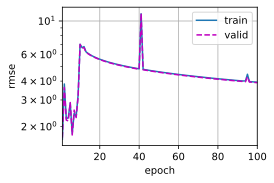

In [13]:
train_features=train_features.to(device)
train_labels=train_labels.to(device)
k, num_epochs, lr, weight_decay, batch_size = 3, 100, 4, 0.01, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

In [14]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net().to(device)
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().cpu().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['Sold Price'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['Sold Price']], axis=1)
    submission.to_csv('submission.csv', index=False)


训练log rmse：0.945272


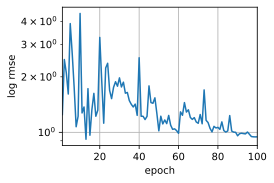

In [15]:
test_features = test_features.to(device)
train_features = train_features.to(device)
train_labels = train_labels.to(device)
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)